# Notebook for reformatting multimodal datasets (RNA+ATAC) (Part 2)

We use RNA/GEX interchangeably. (We will call ATAC as just ATAC).

This is very similar to RNA+ADT notebook in terms of the fact that the cells are shared between the two modalities. We just need to be careful with the following
- (1) cell_id being consistent when merging
- (2) each modalities are normalized separately
- (3) keeping the embeddings from both modalities
- (4) keeping the neighborhoods from both modalities (making sure that we re-compute the neighbors for each modality with the consistent cell indices.)

## Note that this object is already concatenated with multiple donors, as well as the count matrix already has the form of cell x (RNA+ATAC) format.

What we will do:
- subset for only one site/donor (s1d1)
- rename the var with each modality (either RNA or ATAC)
- redo the log-normalization for each modality, then merge (this is pretty much for visualization only)

In [1]:
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import tqdm
import sys
import os
from scipy import sparse

In [27]:
# adata_origin = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/multiome_BMMC_processed.h5ad")
# adata_origin

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [3]:
# adata_origin.obs.Samplename

TAGTTGTCACCCTCAC-1-s1d1     site1_donor1_multiome
CTATGGCCATAACGGG-1-s1d1     site1_donor1_multiome
CCGCACACAGGTTAAA-1-s1d1     site1_donor1_multiome
TCATTTGGTAATGGAA-1-s1d1     site1_donor1_multiome
ACCACATAGGTGTCCA-1-s1d1     site1_donor1_multiome
                                    ...          
AAACCGCGTTTGAGGC-12-s4d9    site4_donor9_multiome
TGACTTAAGTTCCCGT-12-s4d9    site4_donor9_multiome
GCTGTACCACCGTTCC-12-s4d9    site4_donor9_multiome
ACACTTGCAACTAGAA-12-s4d9    site4_donor9_multiome
CACTTAAAGTCTGGGC-12-s4d9    site4_donor9_multiome
Name: Samplename, Length: 69249, dtype: category
Categories (13, object): ['site1_donor1_multiome', 'site1_donor2_multiome', 'site1_donor3_multiome', 'site2_donor1_multiome', ..., 'site3_donor10_multiome', 'site4_donor1_multiome', 'site4_donor8_multiome', 'site4_donor9_multiome']

In [28]:
# # subset the anndata for s1d1 (site1 donor1)
# adata_origin = adata_origin[adata_origin.obs.Samplename=="site1_donor1_multiome"]
# adata_origin

View of AnnData object with n_obs × n_vars = 6224 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

# Muon 

Muon package has vignettes for generating a joint embedding from multiple modalities (generalizable for N number of modalities).

link - https://muon-tutorials.readthedocs.io/en/latest/trimodal/tea-seq/1-TEA-seq-PBMC.html

We will grab that example, and implement the joint embedding method from Hao and Satija, et al., 2020 Cell (Seurat V4)'s weighted nearest neighbor method for computing the joint embedding. Another thing to note is that the Seurat V4 seems to be the "best" joint-embedding method from Lee et al., 2023 (Benchmarking algorithms for joint integration of unpaired and paired single-cell RNA-seq and ATAC-seq data) paper.





In [68]:
# import libraries
import muon as mu
import muon.atac as ac
import muon.prot as pt
import muon.rna as rna
from mudata import MuData

In [72]:
adata_s1d1_ATAC

NameError: name 'adata_s1d1_ATAC' is not defined

In [88]:
# need to specify which PCA, and keys to be used
sc.pp.neighbors(adata_s1d1_ATAC, n_neighbors=10, n_pcs=40, use_rep="ATAC_lsi_full", key_added="ATAC")

In [113]:
# define the Dark2 color palette
# dark2 = plt.get_cmap('Dark2').colors
dark2 = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02', '#a6761d', '#666666']

# add new colors to the palette
new_colors = ['#A95C68', '#587B7F', '#8B6D9C']
dark2_extended = dark2 + new_colors

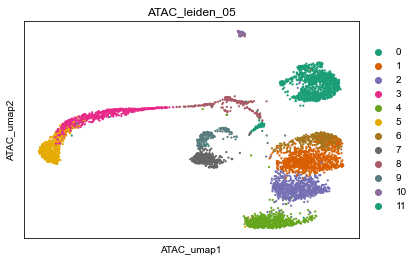

In [115]:
# compute the leiden clustering
sc.tl.leiden(adata_s1d1_ATAC, key_added="ATAC_leiden_05", neighbors_key="ATAC", resolution = 0.5)
sc.pl.embedding(adata_s1d1_ATAC, basis="ATAC_umap", color="ATAC_leiden_05", palette=dark2_extended) 

In [92]:
adata_s1d1_ATAC

AnnData object with n_obs × n_vars = 6224 × 19039
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'ATAC_leiden'
    uns: 'log1p', 'ATAC', 'leiden'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'
    obsp: 'ATAC_distances', 'ATAC_connectivities'

In [163]:
['#1f77b4', '#ff7f0e', '#279e68', '#d62728', 
 '#aa40fc', '#8c564b', '#e377c2', '#b5bd61', 
 '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896']

OverloadedDict, wrapping:
	{'ATAC_gene_activity_var_names': array(['OR4F5', 'OR4F29', 'OR4F16', ..., 'DAZ4', 'BPY2C', 'CDY1'],
      dtype=object), 'dataset_id': 'openproblems_bmmc_multiome', 'genome': 'GRCh38', 'organism': 'human', 'GEX': {'connectivities_key': 'GEX_connectivities', 'distances_key': 'GEX_distances', 'params': {'n_neighbors': 10, 'method': 'umap', 'random_state': 0, 'metric': 'euclidean', 'use_rep': 'GEX_X_pca', 'n_pcs': 40}}, 'leiden': {'params': {'resolution': 0.6, 'random_state': 0, 'n_iterations': -1}}, 'GEX_leiden_05_colors': ['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b', '#e377c2', '#b5bd61', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896'], 'GEX_leiden_03_colors': ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22'], 'GEX_leiden_06_colors': ['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b', '#e377c2', '#b5bd61', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896']}
With ov

In [169]:
pip install pySankey==0.0.1


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [170]:
from pysankey import sankey

# define the colors as the Set1 as the RNA clusters
colors = {
    "0": "#1f77b4",
    "1": "#ff7f0e",
    "2": "#279e68",
    "3": "#d62728",
    "4": "#aa40fc",
    "5": '#8c564b',
    "6": '#e377c2',
    "7": '#b5bd61',
    "8": '#17becf',
    "9": "#aec7e8",
    "10": "#ffbb78",
    "11":"#98df8a",
    "12":"#ff9896"
}


sankey(adata_joint.obs["GEX_leiden_05"], adata_joint.obs["ATAC_leiden_05"], aspect=20, colorDict=colors, fontsize=12)
# plt.savefig("GEX_ADT_leiden_sankey.pdf", dpi=300)

ModuleNotFoundError: No module named 'pysankey'

In [71]:
adata_atac

AnnData object with n_obs × n_vars = 6224 × 116490
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'neighbors'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_pca'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

# Seurat v4 WNN

Updated: 4/12/2023


In [71]:
adata_seurat = sc.read("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_rna_atac_wnn_seurat.h5ad")
adata_seurat

AnnData object with n_obs × n_vars = 6224 × 124476
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'X', 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'cell_type_RNA', 'cell_type_ATAC', 'GEX_leiden_015', 'ATAC_leiden_015', 'manual_annotation_fine', 'manual_annotation_coarse', 'joint_leiden_015', 'joint_leiden_05'
    var: 'count', 'percentile'
    obsm: 'X_lsi', 'X_umap.atac', 'X_umap.rna', 'X_wnn.umap'
    varm: 'LSI'

In [72]:
adata_seurat.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,nCount_ATAC,nFeature_ATAC,nCount_SCT,nFeature_SCT,SCT.weight,ATAC.weight,...,nucleosome_signal,rna_ann,cell_type_RNA,cell_type_ATAC,GEX_leiden_015,ATAC_leiden_015,manual_annotation_fine,manual_annotation_coarse,joint_leiden_015,joint_leiden_05
AAACAGCCAATTAAGG-1,0,1832.0,1204,1.037118,8256.0,3811,1994.0,1203,0.477570,0.522430,...,0.688525,CD4+ T naive,CD4+ T naive,CD4+ T naive,0,5,CD4+T,T_cells,0,3
AAACAGCCAGGCTGTT-1,0,8032.0,2917,2.390438,19866.0,8519,2297.0,1113,0.579224,0.420776,...,0.999325,Lymph prog,Lymph prog,Lymph prog,7,8,Lymph_prog,unassigned,6,9
AAACATGCAAAGCGCA-1,0,2123.0,1307,0.800754,10646.0,4974,2142.0,1304,0.580633,0.419367,...,1.146214,CD4+ T naive,CD4+ T naive,CD4+ T activated,0,1,CD4+T,T_cells,0,7
AAACATGCAATAACCT-1,0,3088.0,1355,0.744819,22412.0,8116,2704.0,1354,0.400453,0.599547,...,0.932788,Erythroblast,Erythroblast,"Proerythroblast, Erythroblast",2,2,unassigned,unassigned,2,1
AAACATGCAATAATGG-1,0,1604.0,1081,1.122195,9012.0,4163,1930.0,1078,0.445056,0.554944,...,0.707914,CD8+ T,CD8+ T,"CD4+ T activated, CD8+ T",3,3,CD8+T,T_cells,0,2


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


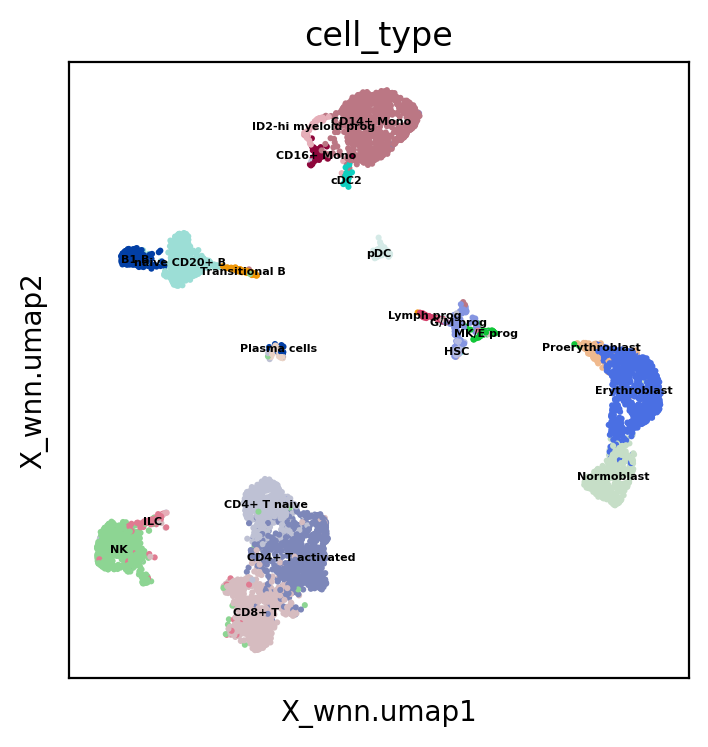

In [73]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default

with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (200)}):
    sc.pl.embedding(adata_seurat, 
                basis="X_wnn.umap", color="cell_type", legend_loc="on data", legend_fontsize=4)

In [74]:
# Load the master adata object again

adata = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_rna_atac_joint_obs_names_sorted.h5ad")
adata

AnnData object with n_obs × n_vars = 6224 × 36852
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'cell_type_RNA', 'cell_type_ATAC'
    var: 'assay'
    uns: 'cell_type_colors'
    obsm: 'X_lsi_full', 'X_lsi_red', 'X_pca_RNA', 'X_umap_ATAC', 'X_umap_RNA'
    obsp: 'connectivities', 'distances'

In [69]:
# save the WNN UMAP to the main adata object
adata.obsm["X_umap_WNN_seurat"] = adata_seurat.obsm["X_wnn.umap"]

# Computing the neighborhood from each modality

## Compute neighborhood for each modality / Compute leiden clustering for each modality

- this functionality does not work in exCellxgene currently. (needs some debugging on what the exCellxgene grabs in the backend).

In [75]:
# Load the cxg object to transfer the annotations to the main object
adata_cxg = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_rna_atac_joint_v5.h5ad")
adata_cxg

AnnData object with n_obs × n_vars = 6224 × 36852
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'cell_type_RNA', 'cell_type_ATAC', 'GEX_leiden_015', 'ATAC_leiden_015', 'manual_annotation_fine', 'manual_annotation_coarse', 'joint_leiden_015', 'joint_leiden_05', 'joint_leiden_025', 'manual_annotation_B_fine'
    var: 'assay'
    uns: 'ATAC_leiden_015_colors', 'GEX_leiden_015_colors', 'cell_type_colors', 'joint_leiden_015_colors', 'joint_leiden_025_colors', 'joint_leiden_05_colors', 'leiden', 'manual_annotation_B_fine_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_RNA', 'X_umap', 'X_umap_ATAC', 'X_umap_RNA', 'X_umap_WNN_muon', 'X_umap_WNN_seurat'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [77]:
# transfer the annotations from the adata_cxg to adata
annotations = ['GEX_leiden_015', 'ATAC_leiden_015', 'manual_annotation_fine', 'manual_annotation_coarse', 
'joint_leiden_015', 'joint_leiden_05', 'joint_leiden_025', 'manual_annotation_B_fine']

for annotation in annotations:
    adata.obs[annotation] = adata_cxg.obs[annotation]

In [78]:
adata

AnnData object with n_obs × n_vars = 6224 × 36852
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'cell_type_RNA', 'cell_type_ATAC', 'GEX_leiden_015', 'ATAC_leiden_015', 'manual_annotation_fine', 'manual_annotation_coarse', 'joint_leiden_015', 'joint_leiden_05', 'joint_leiden_025', 'manual_annotation_B_fine'
    var: 'assay'
    uns: 'cell_type_colors'
    obsm: 'X_lsi_full', 'X_lsi_red', 'X_pca_RNA', 'X_umap_ATAC', 'X_umap_RNA'
    obsp: 'connectivities', 'distances'

In [79]:
# Computing the neighborhoods for RNA(GEX) - we need to specify which PCA, and keys to be used
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40, use_rep="X_pca_RNA", key_added="RNA")
adata

AnnData object with n_obs × n_vars = 6224 × 36852
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'cell_type_RNA', 'cell_type_ATAC', 'GEX_leiden_015', 'ATAC_leiden_015', 'manual_annotation_fine', 'manual_annotation_coarse', 'joint_leiden_015', 'joint_leiden_05', 'joint_leiden_025', 'manual_annotation_B_fine'
    var: 'assay'
    uns: 'cell_type_colors', 'RNA'
    obsm: 'X_lsi_full', 'X_lsi_red', 'X_pca_RNA', 'X_umap_ATAC', 'X_umap_RNA'
    obsp: 'connectivities', 'distances', 'RNA_distances', 'RNA_connectivities'

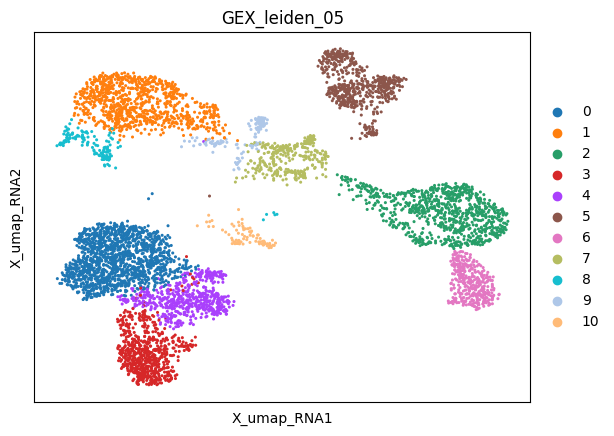

In [80]:
# compute the leiden clustering
sc.tl.leiden(adata, key_added="GEX_leiden_05", neighbors_key="RNA", resolution=0.5)
sc.pl.embedding(adata, basis="X_umap_RNA", color="GEX_leiden_05")

### ATAC

In [81]:
# original dataset had the last column as "nan"s
adata.obsm["X_lsi_red"] = adata.obsm["X_lsi_red"][:,0:38]

In [82]:
# need to specify which PCA, and keys to be used
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40, use_rep="X_lsi_red", key_added="ATAC")
adata

AnnData object with n_obs × n_vars = 6224 × 36852
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'cell_type_RNA', 'cell_type_ATAC', 'GEX_leiden_015', 'ATAC_leiden_015', 'manual_annotation_fine', 'manual_annotation_coarse', 'joint_leiden_015', 'joint_leiden_05', 'joint_leiden_025', 'manual_annotation_B_fine', 'GEX_leiden_05'
    var: 'assay'
    uns: 'cell_type_colors', 'RNA', 'leiden', 'GEX_leiden_05_colors', 'ATAC'
    obsm: 'X_lsi_full', 'X_lsi_red', 'X_pca_RNA', 'X_umap_ATAC', 'X_umap_RNA'
    obsp: 'connectivities', 'distances', 'RNA_distances', 'RNA_connectivities', 'ATAC_distances', 'ATAC_connectivities'

In [83]:
# define the Dark2 color palette
# dark2 = plt.get_cmap('Dark2').colors
dark2 = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02', '#a6761d', '#666666']

# add new colors to the palette
new_colors = ['#A95C68', '#587B7F', '#8B6D9C']
dark2_extended = dark2 + new_colors

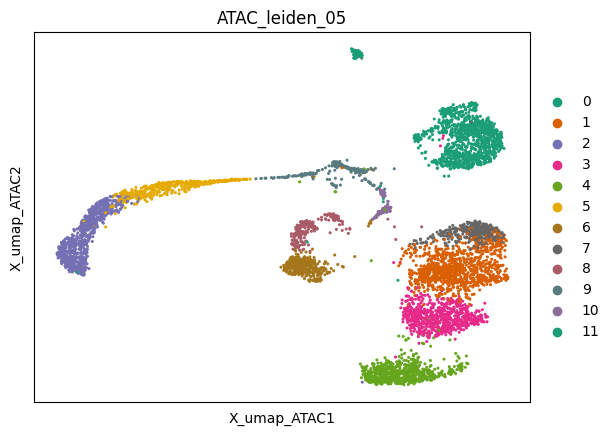

In [84]:
# compute the leiden clustering
sc.tl.leiden(adata, key_added="ATAC_leiden_05", neighbors_key="ATAC", resolution = 0.5)
sc.pl.embedding(adata, basis="X_umap_ATAC", color="ATAC_leiden_05", palette=dark2_extended) 

In [85]:
adata.obsp["ATAC_connectivities"].todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### WNN

In [45]:
adata_seurat = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_rna_atac_wnn_seurat.h5ad")
adata_seurat

AnnData object with n_obs × n_vars = 6224 × 124476
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'X', 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'cell_type_RNA', 'cell_type_ATAC', 'GEX_leiden_015', 'ATAC_leiden_015', 'manual_annotation_fine', 'manual_annotation_coarse', 'joint_leiden_015', 'joint_leiden_05'
    var: 'count', 'percentile'
    obsm: 'X_lsi', 'X_umap.atac', 'X_umap.rna', 'X_wnn.umap'
    varm: 'LSI'

In [86]:
wnn_neighbors = pd.read_csv("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/connectivities",
                            index_col=[0])
wnn_neighbors

,AAACAGCCAATTAAGG.1,AAACAGCCAGGCTGTT.1,AAACATGCAAAGCGCA.1,AAACATGCAATAACCT.1,AAACATGCAATAATGG.1,AAACATGCAATATAGG.1,AAACATGCACTAAGTT.1,AAACATGCAGTATGTT.1,AAACCAACAATTAACC.1,AAACCAACATTAAGCT.1,...,TTTGTGGCAAGGCCAA.1,TTTGTGGCAAGGTCGA.1,TTTGTGGCACAATGTT.1,TTTGTGGCACTGACCG.1,TTTGTGGCAGCATTAT.1,TTTGTGTTCATGTGGT.1,TTTGTGTTCATTTGCT.1,TTTGTGTTCGCCTAAG.1,TTTGTTGGTACGGTAC.1,TTTGTTGGTTCGGTAA.1
AAACAGCCAATTAAGG-1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACAGCCAGGCTGTT-1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATGCAAAGCGCA-1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATGCAATAACCT-1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATGCAATAATGG-1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGTTCATGTGGT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
TTTGTGTTCATTTGCT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
TTTGTGTTCGCCTAAG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
TTTGTTGGTACGGTAC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [87]:
from scipy.sparse import csr_matrix

wnn_neighbors = csr_matrix(wnn_neighbors)
wnn_neighbors

<6224x6224 sparse matrix of type '<class 'numpy.int64'>'
	with 189208 stored elements in Compressed Sparse Row format>

In [88]:
adata.obsp["WNN_connectivities"] = wnn_neighbors

In [89]:
adata

AnnData object with n_obs × n_vars = 6224 × 36852
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'cell_type_RNA', 'cell_type_ATAC', 'GEX_leiden_015', 'ATAC_leiden_015', 'manual_annotation_fine', 'manual_annotation_coarse', 'joint_leiden_015', 'joint_leiden_05', 'joint_leiden_025', 'manual_annotation_B_fine', 'GEX_leiden_05', 'ATAC_leiden_05'
    var: 'assay'
    uns: 'cell_type_colors', 'RNA', 'leiden', 'GEX_leiden_05_colors', 'ATAC', 'ATAC_leiden_05_colors'
    obsm: 'X_lsi_full', 'X_lsi_red', 'X_pca_RNA', 'X_umap_ATAC', 'X_umap_RNA'
    obsp: 'connectivities', 'distances', 'RNA_distances', 'RNA_connectivities', 'ATAC_distances', 'ATAC_connectivities', 'WNN_connectivities'

In [90]:
adata.write_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_rna_atac_joint_v7.h5ad")